<a href="https://colab.research.google.com/github/mnocerino23/MLB-Salary-Regressions/blob/main/Pitcher_Regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this Jupyter Notebook, I will build regression models to predict salary (in millions) for MLB position pitchers. I will experiment with different modeling techniques such as multivariate linear, lasso, ridge, and neural network regressions

In [564]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [565]:
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler

In [566]:
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso

In [567]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [568]:
#read in position player stats
pitchers_train = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/MLB/pitcher_train.csv')
pitchers_test = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/MLB/pitcher_test.csv')

# Final check for null values:

In [569]:
#no null values
pitchers_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 43 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     300 non-null    object 
 1   throws   300 non-null    object 
 2   age      300 non-null    int64  
 3   stints   300 non-null    int64  
 4   teamID   300 non-null    object 
 5   LG       300 non-null    object 
 6   POS1     300 non-null    object 
 7   W        300 non-null    int64  
 8   L        300 non-null    int64  
 9   CG       300 non-null    int64  
 10  ShO      300 non-null    int64  
 11  GP       300 non-null    int64  
 12  GS       300 non-null    int64  
 13  SV       300 non-null    int64  
 14  GF       300 non-null    int64  
 15  IPOuts   300 non-null    int64  
 16   IP      300 non-null    float64
 17   ERA     300 non-null    float64
 18  HA       300 non-null    int64  
 19  ER       300 non-null    int64  
 20  HRA      300 non-null    int64  
 21  BBA      300 non

In [570]:
#test data also has no nulls so we are good
pitchers_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 43 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     75 non-null     object 
 1   throws   75 non-null     object 
 2   age      75 non-null     int64  
 3   stints   75 non-null     int64  
 4   teamID   75 non-null     object 
 5   LG       75 non-null     object 
 6   POS1     75 non-null     object 
 7   W        75 non-null     int64  
 8   L        75 non-null     int64  
 9   CG       75 non-null     int64  
 10  ShO      75 non-null     int64  
 11  GP       75 non-null     int64  
 12  GS       75 non-null     int64  
 13  SV       75 non-null     int64  
 14  GF       75 non-null     int64  
 15  IPOuts   75 non-null     int64  
 16   IP      75 non-null     float64
 17   ERA     75 non-null     float64
 18  HA       75 non-null     int64  
 19  ER       75 non-null     int64  
 20  HRA      75 non-null     int64  
 21  BBA      75 non-nu

In [571]:
pitchers_train.head(3)

,name,throws,age,stints,teamID,LG,POS1,W,L,CG,...,WHIP,WRIP,HRBIB,RAVG,FIP,DERA,STUFF,GURU,salary,WAR
0,Da Hudson,R,24,1,STL,NL,Starter,16,7,0,...,1.41,1.75,0.06,4.12,4.91,4.73,11,38,0.491965,0.6
1,Ad Ottavino,R,33,1,NYA,AL,Reliever,6,5,0,...,1.31,1.36,0.05,2.31,3.43,3.29,187,63,9.000000,1.3
2,Mi Soroka,R,21,1,ATL,NL,Starter,13,4,0,...,1.11,1.04,0.04,2.89,3.44,3.43,62,91,0.411792,3.8


In [572]:
pitchers_test.head(3)

,name,throws,age,stints,teamID,LG,POS1,W,L,CG,...,WHIP,WRIP,HRBIB,RAVG,FIP,DERA,STUFF,GURU,salary,WAR
0,Ja Diaz,R,28,1,COL,NL,Reliever,6,4,0,...,1.30,1.54,0.07,5.31,3.69,3.60,123,44,0.390904,0.9
1,Wa Buehler,R,24,1,LAN,NL,Starter,14,4,2,...,1.04,1.30,0.06,3.80,2.99,2.93,206,147,0.570000,5.0
2,Jo Suarez,L,21,1,LAA,AL,Reliever,2,6,0,...,1.64,3.25,0.16,7.44,6.71,6.27,6,9,0.265576,-0.6


In [573]:
#drop unncesary columns from both datasets

pitchers_train.drop(columns = ['name','stints', 'LG', 'teamID'], inplace = True)
pitchers_test.drop(columns = ['name','stints', 'LG', 'teamID'], inplace = True)
pitchers_test.head()

,throws,age,POS1,W,L,CG,ShO,GP,GS,SV,...,WHIP,WRIP,HRBIB,RAVG,FIP,DERA,STUFF,GURU,salary,WAR
0,R,28,Reliever,6,4,0,0,56,0,5,...,1.30,1.54,0.07,5.31,3.69,3.60,123,44,0.390904,0.9
1,R,24,Starter,14,4,2,0,30,30,0,...,1.04,1.30,0.06,3.80,2.99,2.93,206,147,0.570000,5.0
2,L,21,Reliever,2,6,0,0,19,15,0,...,1.64,3.25,0.16,7.44,6.71,6.27,6,9,0.265576,-0.6
3,R,23,Starter,11,8,0,0,33,33,0,...,0.97,1.55,0.08,2.84,3.45,3.32,171,107,0.562100,4.9
4,R,26,Reliever,4,4,0,0,27,9,0,...,1.67,1.61,0.05,5.77,4.58,4.42,31,23,0.704256,0.6


# Reminding ourselves of the train and test data shapes (we performed an 80-20 split previously then normalized both independently)

In [574]:
print('Position Players Train:')
print('Train dataset dimensions: ', pitchers_train.shape, '\n')

print('Position Players Test:')
print('Test dataset dimensions: ', pitchers_test.shape, '\n')

Position Players Train:
Train dataset dimensions:  (300, 39) 

Position Players Test:
Test dataset dimensions:  (75, 39) 



# Add on feature for under rookie contract. If a player is 25 or under they are on their rookie contract else they are typically not

In [575]:
pitchers_train['Rookie contract'] = ''
pitchers_test['Rookie contract'] = ''

for index, row in pitchers_train.iterrows():
  if pitchers_train.at[index,'age'] <= 25:
    pitchers_train.at[index,'Rookie contract'] = 1
  else:
    pitchers_train.at[index,'Rookie contract'] = 0

for index, row in pitchers_test.iterrows():
  if pitchers_test.at[index,'age'] <= 25:
    pitchers_test.at[index,'Rookie contract'] = 1
  else:
    pitchers_test.at[index,'Rookie contract'] = 0

# One-hot encode position:

In [576]:
dummy_position = pd.get_dummies(pitchers_train['POS1'])
dummy_throws = pd.get_dummies(pitchers_train['throws'], prefix = 'throws')
items = [dummy_position, dummy_throws]
for item in items:
  pitchers_train = pd.merge(left = pitchers_train, right = item, left_index = True, right_index = True)

pitchers_train.drop(columns = ['POS1', 'throws'], axis = 1, inplace = True)

In [577]:
dummy_pos = pd.get_dummies(pitchers_test['POS1'])
dummy_throw = pd.get_dummies(pitchers_test['throws'], prefix = 'throws')
items = [dummy_pos, dummy_throw]

for item in items:
  pitchers_test = pd.merge(left = pitchers_test, right = item, left_index = True, right_index = True)

pitchers_test.drop(columns = ['POS1', 'throws'], axis = 1, inplace = True)

In [578]:
#display both  dataframes to ensure we have done this correctly
pitchers_train.head(3)

,age,W,L,CG,ShO,GP,GS,SV,GF,IPOuts,...,DERA,STUFF,GURU,salary,WAR,Rookie contract,Reliever,Starter,throws_L,throws_R
0,24,16,7,0,0,33,32,1,1,524,...,4.73,11,38,0.491965,0.6,1,0,1,0,1
1,33,6,5,0,0,73,0,2,7,199,...,3.29,187,63,9.000000,1.3,0,1,0,0,1
2,21,13,4,0,0,29,29,0,0,524,...,3.43,62,91,0.411792,3.8,1,0,1,0,1


In [579]:
pitchers_test.head(3)

,age,W,L,CG,ShO,GP,GS,SV,GF,IPOuts,...,DERA,STUFF,GURU,salary,WAR,Rookie contract,Reliever,Starter,throws_L,throws_R
0,28,6,4,0,0,56,0,5,20,173,...,3.60,123,44,0.390904,0.9,0,1,0,0,1
1,24,14,4,2,0,30,30,0,0,547,...,2.93,206,147,0.570000,5.0,1,0,1,0,1
2,21,2,6,0,0,19,15,0,0,243,...,6.27,6,9,0.265576,-0.6,1,1,0,1,0


In [580]:
#pitchers train has two invalid entries which are causing issues. We will drop both rows
pitchers_train.head(10)
print(pitchers_train.at[8, ' HR9 '])

pitchers_train = pitchers_train.drop(8)
pitchers_train = pitchers_train.reset_index(drop = True)

print(pitchers_train.at[31, ' GURU '])
pitchers_train = pitchers_train.drop(31)
pitchers_train = pitchers_train.reset_index(drop = True)

 -   
 1,325 


In [581]:
pitchers_train.head(10)

,age,W,L,CG,ShO,GP,GS,SV,GF,IPOuts,...,DERA,STUFF,GURU,salary,WAR,Rookie contract,Reliever,Starter,throws_L,throws_R
0,24,16,7,0,0,33,32,1,1,524,...,4.73,11,38,0.491965,0.6,1,0,1,0,1
1,33,6,5,0,0,73,0,2,7,199,...,3.29,187,63,9.000000,1.3,0,1,0,0,1
2,21,13,4,0,0,29,29,0,0,524,...,3.43,62,91,0.411792,3.8,1,0,1,0,1
3,34,15,4,1,1,33,33,0,0,554,...,4.90,8,36,6.000000,1.7,0,0,1,0,1
4,27,6,11,0,0,46,16,0,4,344,...,4.10,95,42,0.581700,1.5,0,1,0,1,0
5,29,2,11,0,0,60,0,2,18,182,...,4.70,21,18,1.125000,-0.4,0,1,0,1,0
6,26,1,0,0,0,23,2,0,3,69,...,3.15,161,52,0.568600,0.5,0,1,0,0,1
7,35,2,4,0,0,71,1,1,21,207,...,3.46,151,54,6.500000,1.0,0,1,0,0,1
8,28,3,3,0,0,32,3,0,5,147,...,4.64,30,17,0.299827,0.2,0,1,0,0,1
9,31,2,4,0,0,44,0,5,14,144,...,3.74,58,35,0.393888,0.6,0,1,0,0,1


# Normalize input features using min-max normalization

In [582]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [583]:
train_target = pitchers_train['salary']

train_features = pitchers_train.drop(columns = ['salary'])
col = train_features.columns
train_features = scaler.fit_transform(train_features)
train_features = pd.DataFrame(data=train_features, columns=col)

In [584]:
test_target = pitchers_test['salary']

test_features = pitchers_test.drop(columns = ['salary'])
test_features = scaler.fit_transform(test_features)
test_features = pd.DataFrame(data=test_features, columns=col)

# Feature Selection

Vary the number of features we select to find optimal amount. I found that k = 12 features produces the best model with MAE of 3.49 million

In [585]:
#top_features_ordered = []

In [586]:
#best_features = SelectKBest(f_regression, k=12)
#k_best_data = best_features.fit_transform(train_features, train_target)
#mask = best_features.get_support()
#new_features = train_features.columns[mask]
#for item in new_features:
  #if item not in top_features_ordered:
   # top_features_ordered.append(item)

In [587]:
#count = 1
#for item in top_features_ordered:
  #print(count, '. ', item)
  #count += 1

In [588]:
train_selected_X = train_features[['age', ' ERA ', 'L', ' GURU ', 'WAR', 'Rookie contract', ' WHIP ', 'Starter']]
train_y = train_target

test_selected_X = test_features[['age', ' ERA ', 'L', ' GURU ', 'WAR', 'Rookie contract', ' WHIP ', 'Starter']]
test_y = test_target

In [589]:
print('Train Features:')
print('train_selected_X dimensions: ', train_selected_X.shape)
print('train_y dimensions:', train_y.shape, '\n')

print('Test Features:')
print('test_data_X dimensions: ', test_selected_X.shape)
print('test_data_y dimensions:', test_y.shape, '\n')

Train Features:
train_selected_X dimensions:  (298, 8)
train_y dimensions: (298,) 

Test Features:
test_data_X dimensions:  (75, 8)
test_data_y dimensions: (75,) 



# Multivariate Linear Regression

In [590]:
multivariate_regression = linear_model.LinearRegression()
multivariate_regression.fit(train_selected_X, train_y)

LinearRegression()

# Beta values (coefficients) and intercept for our multivariate linear regression:

In [591]:
multivariate_regression.coef_

array([13.71858001,  4.59547493,  0.13674579,  2.07428557,  8.72698159,
        0.95772386,  1.24109881,  2.12781634])

In [592]:
multivariate_regression.intercept_

-9.630627662994607

In [593]:
y_pred = multivariate_regression.predict(test_selected_X)

In [594]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_pred), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_pred), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_pred)))

Mean Squared Error:  27.84094646690154 

Mean Absolute Error:  3.3952575126696627 

Root Mean Squared Error:  5.276452071885192


# Ridge Regression

In [595]:
ridge_regression = Ridge(alpha = 3.5)
ridge_regression.fit(train_selected_X, train_y)

Ridge(alpha=3.5)

In [596]:
ridge_regression.coef_

array([ 8.87982159,  1.76785427,  0.654568  ,  1.53910363,  4.25748461,
       -0.34925564,  0.69632578,  3.00880434])

In [597]:
ridge_regression.intercept_

-4.511978412837353

In [598]:
y_predicted = ridge_regression.predict(test_selected_X)

In [599]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_predicted), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_predicted), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_predicted)))

Mean Squared Error:  26.926501742758933 

Mean Absolute Error:  3.0385539641531794 

Root Mean Squared Error:  5.189075230015358


# Lasso Regression

In [600]:
lasso_regression = Lasso(alpha = 3.5)
lasso_regression.fit(train_selected_X, train_y)

Lasso(alpha=3.5)

In [601]:
lasso_regression.coef_

array([ 0., -0.,  0.,  0.,  0., -0., -0.,  0.])

In [602]:
lasso_regression.intercept_

3.0052020771812082

In [603]:
y_predicted_lasso = lasso_regression.predict(test_selected_X)

In [604]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_predicted_lasso), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_predicted_lasso), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_predicted_lasso)))

Mean Squared Error:  38.38927665084346 

Mean Absolute Error:  4.23024424621924 

Root Mean Squared Error:  6.195908057003708


# Regression with Deep Learning

In [605]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

In [606]:
tf.random.set_seed(5)

network1 = tf.keras.models.Sequential()
network1.add(tf.keras.Input(shape=(41,)))
network1.add(tf.keras.layers.Dense(15, activation='relu'))
network1.add(tf.keras.layers.Dense(15, activation='tanh'))
network1.add(tf.keras.layers.Dense(15, activation='relu'))
network1.add(tf.keras.layers.Dense(1))

network1.compile(
   loss=tf.keras.losses.MeanAbsoluteError(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics='mean_absolute_error')

history1 = network1.fit(train_features, train_target, epochs=75,validation_data=(test_features,test_target))

Epoch 1/75
10/10 [==============================] - 1s 20ms/step - loss: 2.9631 - mean_absolute_error: 2.9631 - val_loss: 4.0488 - val_mean_absolute_error: 4.0488
Epoch 2/75
10/10 [==============================] - 0s 7ms/step - loss: 2.6837 - mean_absolute_error: 2.6837 - val_loss: 3.8653 - val_mean_absolute_error: 3.8653
Epoch 3/75
10/10 [==============================] - 0s 4ms/step - loss: 2.5763 - mean_absolute_error: 2.5763 - val_loss: 3.8498 - val_mean_absolute_error: 3.8498
Epoch 4/75
10/10 [==============================] - 0s 5ms/step - loss: 2.5694 - mean_absolute_error: 2.5694 - val_loss: 3.8353 - val_mean_absolute_error: 3.8353
Epoch 5/75
10/10 [==============================] - 0s 5ms/step - loss: 2.5415 - mean_absolute_error: 2.5415 - val_loss: 3.8059 - val_mean_absolute_error: 3.8059
Epoch 6/75
10/10 [==============================] - 0s 4ms/step - loss: 2.5203 - mean_absolute_error: 2.5203 - val_loss: 3.7861 - val_mean_absolute_error: 3.7861
Epoch 7/75
10/10 [=========

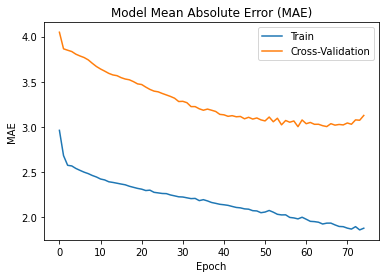

In [607]:
from matplotlib import pyplot as plt
plt.plot(history1.history['mean_absolute_error'])
plt.plot(history1.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()

In [608]:
tf.random.set_seed(5)

network2 = tf.keras.models.Sequential()
network2.add(tf.keras.Input(shape=(41,)))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(1))

network2.compile(
   loss=tf.keras.losses.MeanAbsoluteError(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics='mean_absolute_error')

history2 = network2.fit(train_features, train_target, epochs=80,validation_data=(test_features,test_target))

Epoch 1/80
10/10 [==============================] - 1s 59ms/step - loss: 2.9608 - mean_absolute_error: 2.9608 - val_loss: 4.2386 - val_mean_absolute_error: 4.2386
Epoch 2/80
10/10 [==============================] - 0s 4ms/step - loss: 2.8183 - mean_absolute_error: 2.8183 - val_loss: 4.0349 - val_mean_absolute_error: 4.0349
Epoch 3/80
10/10 [==============================] - 0s 6ms/step - loss: 2.6375 - mean_absolute_error: 2.6375 - val_loss: 3.8855 - val_mean_absolute_error: 3.8855
Epoch 4/80
10/10 [==============================] - 0s 6ms/step - loss: 2.5999 - mean_absolute_error: 2.5999 - val_loss: 3.8581 - val_mean_absolute_error: 3.8581
Epoch 5/80
10/10 [==============================] - 0s 4ms/step - loss: 2.5888 - mean_absolute_error: 2.5888 - val_loss: 3.8324 - val_mean_absolute_error: 3.8324
Epoch 6/80
10/10 [==============================] - 0s 7ms/step - loss: 2.5669 - mean_absolute_error: 2.5669 - val_loss: 3.8090 - val_mean_absolute_error: 3.8090
Epoch 7/80
10/10 [=========

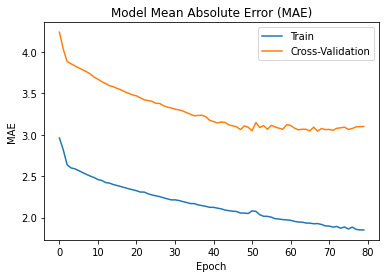

In [609]:
from matplotlib import pyplot as plt
plt.plot(history2.history['mean_absolute_error'])
plt.plot(history2.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()

In [611]:
tf.random.set_seed(5)

network3 = tf.keras.models.Sequential()
network3.add(tf.keras.Input(shape=(8,)))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(1))

network3.compile(
   loss=tf.keras.losses.MeanAbsoluteError(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics='mean_absolute_error')

history3 = network3.fit(train_selected_X, train_target, epochs=50,validation_data=(test_selected_X,test_target))

Epoch 1/50
10/10 [==============================] - 1s 35ms/step - loss: 2.9718 - mean_absolute_error: 2.9718 - val_loss: 4.2656 - val_mean_absolute_error: 4.2656
Epoch 2/50
10/10 [==============================] - 0s 8ms/step - loss: 2.8373 - mean_absolute_error: 2.8373 - val_loss: 4.0792 - val_mean_absolute_error: 4.0792
Epoch 3/50
10/10 [==============================] - 0s 7ms/step - loss: 2.6503 - mean_absolute_error: 2.6503 - val_loss: 3.9028 - val_mean_absolute_error: 3.9028
Epoch 4/50
10/10 [==============================] - 0s 8ms/step - loss: 2.5854 - mean_absolute_error: 2.5854 - val_loss: 3.8464 - val_mean_absolute_error: 3.8464
Epoch 5/50
10/10 [==============================] - 0s 8ms/step - loss: 2.5688 - mean_absolute_error: 2.5688 - val_loss: 3.8177 - val_mean_absolute_error: 3.8177
Epoch 6/50
10/10 [==============================] - 0s 8ms/step - loss: 2.5502 - mean_absolute_error: 2.5502 - val_loss: 3.8020 - val_mean_absolute_error: 3.8020
Epoch 7/50
10/10 [=========

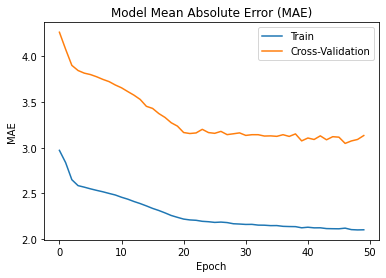

In [612]:
from matplotlib import pyplot as plt
plt.plot(history3.history['mean_absolute_error'])
plt.plot(history3.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()